In [1]:
# Importamos las librerias 
import pandas as pd
from funciones_mecanizados import cortar
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix

In [2]:
from numpy.random import seed
seed(0)
tf.random.set_seed(11)

In [3]:
# Cargamos el dataset preprocesado.
H = pd.read_csv('data/H_norm.csv')

columnas = ['P_FRQ', 'RISE', 'COUN', 'ENER','DURATION', 'AMP',
            'A_FRQ', 'RMS','ASL', 'PCNTS', 'R_FRQ', 'I_FRQ',
            'SIG_STRNGTH', 'ABS_ENERGY','C_FRQ', 'P_MARSE']

# Nos quedamos con algunos datos del fresado
#corte1 = [1,2]
#corte2 = [2,2.7]

#mecanizado = pd.concat([cortar(H, corte1), cortar(H, corte2)])

print('H1:',H[H['Herramienta']=='H1'].shape)
print('H2:',H[H['Herramienta']=='H2'].shape)
print('H3:',H[H['Herramienta']=='H3'].shape)

# Eliminamos muestras con baja energía
#nivel_filtro = 0
#mecanizado.drop(mecanizado[mecanizado['ENER']<nivel_filtro].index, axis=0, inplace=True)

# Mezclamos el dataset
mecanizado = shuffle(H, random_state=1)

H1: (3108, 21)
H2: (2910, 21)
H3: (2996, 21)


In [4]:
# Pasamos la variable objetivo de categórica a numérica
mecanizado['Herramienta'].replace({'H1':0, 'H2':1, 'H3':2}, inplace=True)

C:\Users\agust\Anaconda3\lib\site-packages\pandas\core\series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [5]:
# Dividimos el dataset en datos de entrenamiento y de prueba. Usamos StratifiedShufflesSplir 
# para mantener la proporción de las clases objetivo.

from sklearn.model_selection import StratifiedShuffleSplit

train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=11)

for train_index, test_index in train_test_split.split(mecanizado, mecanizado['Herramienta']):
    train_data = mecanizado.iloc[train_index]
    test_data = mecanizado.iloc[test_index]

In [6]:
train_data['Herramienta'].value_counts()

0    2486
2    2397
1    2328
Name: Herramienta, dtype: int64

In [7]:
# Del con junto de entrenamiento extraemos una porción para usar como datos de validación. 
train_valid_split = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=12)
for train_index, valid_index in train_valid_split.split(train_data, train_data['Herramienta']):
    train = train_data.iloc[train_index]
    valid = train_data.iloc[valid_index]

In [8]:
test_data['Herramienta'].value_counts()

0    622
2    599
1    582
Name: Herramienta, dtype: int64

In [9]:
# Separamos las variables objetivo de los datos de entrenamiento y de validación.
X_train = train[columnas]
y_train = train['Herramienta']

X_valid = valid[columnas]
y_valid = valid['Herramienta']

In [10]:
# Creamos el perceptrón multicapa

nn=[50, 900, 150, 3] # Tamaño de cada capa
n_input = [len(columnas)] # Cantidad de entradas

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=n_input), # Entrada
    keras.layers.Dense(nn[0], activation="relu"), # Capas ocultas x3
    keras.layers.Dense(nn[1], activation="relu"),
    keras.layers.Dense(nn[2], activation="relu"),
    keras.layers.Dense(nn[3], activation="softmax") # Salida
])

In [11]:
# Configuramos los parámetros de entrenamiento y metricas de predicción.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.13),
              metrics=["accuracy"])

from tensorflow.keras.callbacks import EarlyStopping # Detiene el entrenamiento cuando no ve una mejora

early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=20,
                               restore_best_weights=True)

In [12]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size = 32,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping])

Epoch 1/500
181/181 [==============================] - 2s 6ms/step - loss: 1.0674 - accuracy: 0.4157 - val_loss: 1.0508 - val_accuracy: 0.4532
Epoch 2/500
181/181 [==============================] - 1s 3ms/step - loss: 0.9958 - accuracy: 0.4992 - val_loss: 0.9823 - val_accuracy: 0.5038
Epoch 3/500
181/181 [==============================] - 1s 3ms/step - loss: 0.9559 - accuracy: 0.5246 - val_loss: 0.8938 - val_accuracy: 0.5856
Epoch 4/500
181/181 [==============================] - 1s 3ms/step - loss: 0.9046 - accuracy: 0.5708 - val_loss: 1.0730 - val_accuracy: 0.4567
Epoch 5/500
181/181 [==============================] - 1s 3ms/step - loss: 0.8653 - accuracy: 0.5952 - val_loss: 0.9123 - val_accuracy: 0.5495
Epoch 6/500
181/181 [==============================] - 1s 3ms/step - loss: 0.8356 - accuracy: 0.6106 - val_loss: 0.8737 - val_accuracy: 0.5599
Epoch 7/500
181/181 [==============================] - 1s 3ms/step - loss: 0.8091 - accuracy: 0.6254 - val_loss: 0.8266 - val_accuracy: 0.6050

Epoch 114/500
181/181 [==============================] - 1s 3ms/step - loss: 0.1176 - accuracy: 0.9537 - val_loss: 0.6771 - val_accuracy: 0.8295
Epoch 115/500
181/181 [==============================] - 1s 3ms/step - loss: 0.1769 - accuracy: 0.9331 - val_loss: 0.3307 - val_accuracy: 0.8981
Epoch 116/500
181/181 [==============================] - 1s 3ms/step - loss: 0.0579 - accuracy: 0.9808 - val_loss: 0.2768 - val_accuracy: 0.9210
Epoch 117/500
181/181 [==============================] - 1s 4ms/step - loss: 0.0747 - accuracy: 0.9724 - val_loss: 0.4266 - val_accuracy: 0.8884
Epoch 118/500
181/181 [==============================] - 1s 3ms/step - loss: 0.1060 - accuracy: 0.9625 - val_loss: 0.3558 - val_accuracy: 0.9044
Epoch 119/500
181/181 [==============================] - 1s 4ms/step - loss: 0.0821 - accuracy: 0.9682 - val_loss: 0.3810 - val_accuracy: 0.9009
Epoch 120/500
181/181 [==============================] - 1s 3ms/step - loss: 0.0564 - accuracy: 0.9815 - val_loss: 0.3346 - val_ac

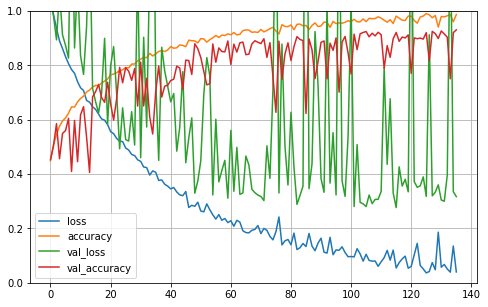

In [13]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [14]:
X_test = test_data[columnas]
y_test = test_data['Herramienta']
model.evaluate(X_test, y_test)

57/57 [==============================] - 0s 1ms/step - loss: 0.2836 - accuracy: 0.9257


[0.2836421728134155, 0.9256794452667236]

In [15]:
import numpy as np
predicciones = np.argmax(model.predict(X_test), axis=-1)

In [16]:
#Matriz de confusión
conf_matrix = confusion_matrix(y_test, predicciones,labels=[0,1,2])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

    H1_predicción  H2_predicción  H3_predicción
H1            577             14             31
H2             23            539             20
H3             32             14            553


In [17]:
#Scores
from sklearn.metrics import classification_report
print (classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       622
           1       0.95      0.93      0.94       582
           2       0.92      0.92      0.92       599

    accuracy                           0.93      1803
   macro avg       0.93      0.93      0.93      1803
weighted avg       0.93      0.93      0.93      1803



In [18]:
predicciones_erroneas = mecanizado.loc[y_test[(predicciones == y_test) == 0].index]

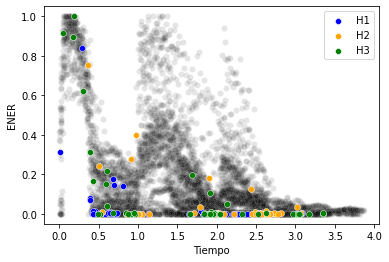

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

variable = 'ENER'
sns.scatterplot(data=mecanizado, x='Tiempo',y=variable, color='black', alpha=0.1)
color = ['blue','orange','green']
herramienta = ['H1','H2','H3']
for i in range(3):
    sns.scatterplot(data=predicciones_erroneas[predicciones_erroneas['Herramienta']==i],
                    x='Tiempo', y=variable, color=color[i], label=herramienta[i])

array([[<AxesSubplot:title={'center':'P_FRQ'}>,
        <AxesSubplot:title={'center':'RISE'}>,
        <AxesSubplot:title={'center':'COUN'}>,
        <AxesSubplot:title={'center':'ENER'}>],
       [<AxesSubplot:title={'center':'DURATION'}>,
        <AxesSubplot:title={'center':'AMP'}>,
        <AxesSubplot:title={'center':'A_FRQ'}>,
        <AxesSubplot:title={'center':'RMS'}>],
       [<AxesSubplot:title={'center':'ASL'}>,
        <AxesSubplot:title={'center':'PCNTS'}>,
        <AxesSubplot:title={'center':'R_FRQ'}>,
        <AxesSubplot:title={'center':'I_FRQ'}>],
       [<AxesSubplot:title={'center':'SIG_STRNGTH'}>,
        <AxesSubplot:title={'center':'ABS_ENERGY'}>,
        <AxesSubplot:title={'center':'C_FRQ'}>,
        <AxesSubplot:title={'center':'P_MARSE'}>]], dtype=object)

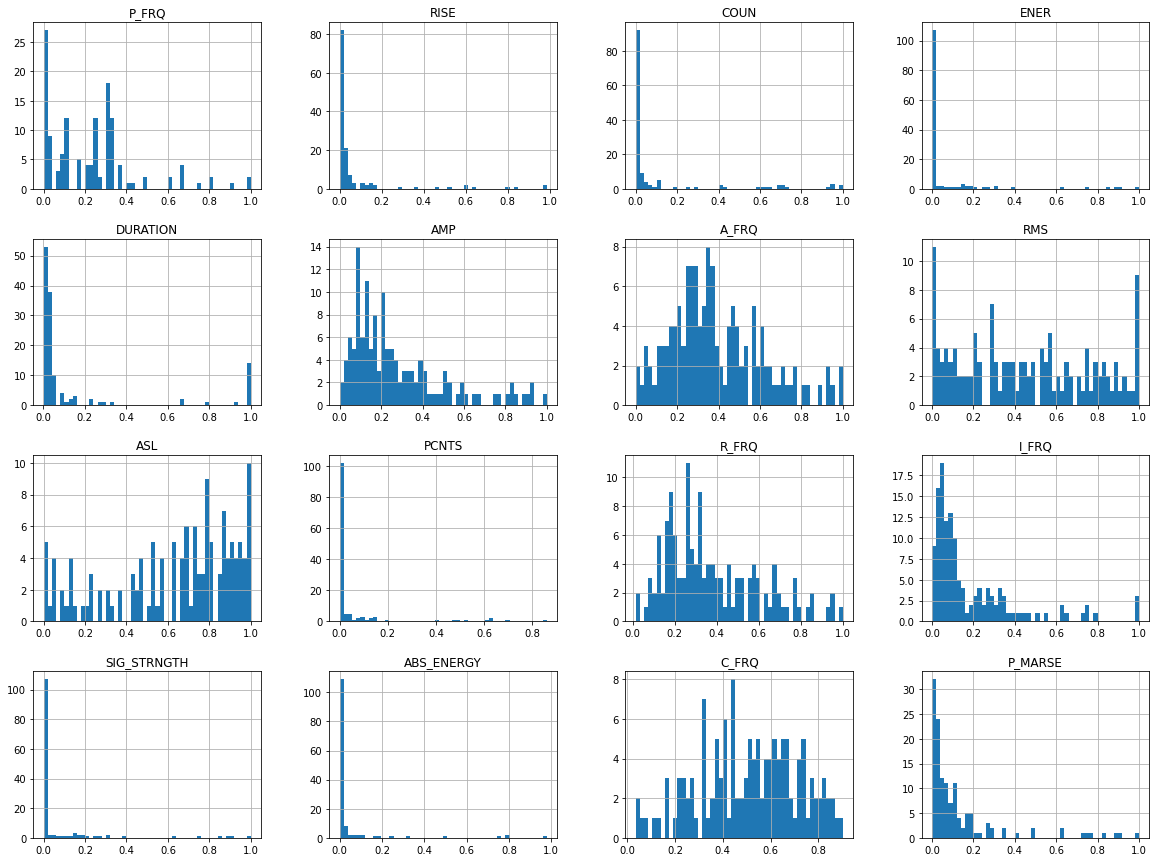

In [20]:
predicciones_erroneas[columnas].hist(bins=50, figsize=(20,15))

In [21]:
predicciones_erroneas['Herramienta'].value_counts()

2    46
0    45
1    43
Name: Herramienta, dtype: int64